### Imports

In [1]:
import os
import sys
import glob
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
from jax import vmap, jit
import jax.random as jr
# set 64-bit mode
jax.config.update("jax_enable_x64", True)
import equinox as eqx

from scipy import signal, interpolate, stats
from ddfa_node import embed_data, takens_embedding, change_trial_length, split_data, get_aics, get_λs, phaser, stats as statistics, jax_utils
import ddfa_node

from tqdm.auto import tqdm

from scipy.signal import savgol_filter
from ddfa_node.networks.jax_utils import NeuralODE
import diffrax
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

import warnings
%load_ext autoreload
%autoreload 2

plt.style.use("seaborn-v0_8-deep")

### Load Data

In [2]:
window_length = 50
polyorder = 5
data = jnp.load("/home/michael/Synology/Julia/data/VDP_SDEs.npy")[25:-20, ::2, :1]
feats = data.shape[-1]
n_trials = data.shape[0]
new_data = np.zeros((n_trials, data.shape[1], data.shape[2]))
for trial in range(n_trials):
    new_data[trial, :, :feats] = savgol_filter(data[trial, :, :], window_length=window_length, polyorder=polyorder, axis=0)
    # new_data[trial, :, feats:] = savgol_filter(data[trial, :, :], window_length=window_length, polyorder=polyorder, axis=0, deriv=1)

# Standardize the data
new_data = (new_data - jnp.mean(new_data, axis=1)[:, None, :]) / jnp.std(new_data, axis=1)[:, None, :]
data = new_data
τ = 32
k = 4
data_tde = takens_embedding(data[:, :, :1], τ, k)

### Load Model

In [3]:
model = NeuralODE(data_size=4, 
                  width_size=128, 
                  hidden_size=256, 
                  ode_size=8, 
                  depth=3, 
                  augment_dims=0, 
                  key=jax.random.PRNGKey(0))
# deserialize the model
model = eqx.tree_deserialise_leaves("outputs/vdp_model.eqx", model)

### Run SDE solve

In [48]:
new_ts = jnp.linspace(0, 100, 10000)
seeding_steps = 100
out = jax.vmap(model, in_axes=(None, 0))(new_ts, data_tde[:, 0:seeding_steps, :])

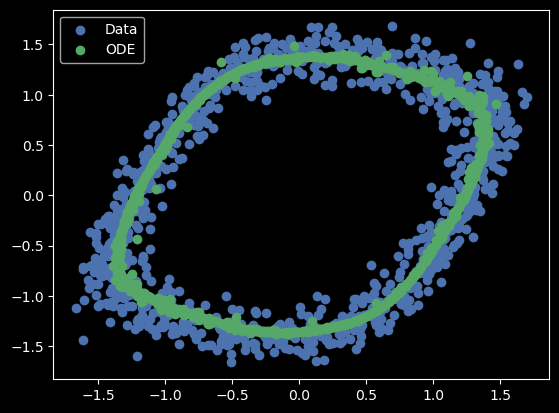

In [49]:
trial = -1
plt.scatter(data_tde[trial, ::10, 0], data_tde[trial, ::10, 1], label="Data")
plt.scatter(out[trial, ::10, 0], out[trial, ::10, 1], label="ODE")
plt.legend()
plt.show()

In [52]:
@eqx.filter_jit
def solve_sde(model, new_ts, yi, diffusion):
    t0, t1 = new_ts[0], new_ts[-1]
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jr.PRNGKey(0))
    terms = MultiTerm(ODETerm(model.func), ControlTerm(diffusion, brownian_motion))
    if model.use_recurrence:
        hidden = jnp.zeros(model.cell.hidden_size)
        for yi_i in yi[::-1]:
            hidden = model.cell(yi_i, hidden)
        y0 = model.hidden_to_ode(hidden)
    else:
        y0 = yi[0, :]
        # Pad the input if augment_dims > 0
        if model.padding_layer is not None:
            y0 = model.padding_layer(y0)

    solution = diffrax.diffeqsolve(
                terms,
                diffrax.Euler(),
                t0=t0,
                t1=t1,
                dt0=new_ts[1] - new_ts[0],
                y0=y0,
                saveat=diffrax.SaveAt(ts=new_ts),
                max_steps=None,
            )
    ys = solution.ys
    if model.use_recurrence or model.padding_layer is not None:
        out = jax.vmap(model.ode_to_data)(ys)
    else:
        out = ys
    return out

def diffusion(t, y, args):
    noise_std = 0.08
    return jr.normal(jr.PRNGKey(jnp.int32(t)), shape=y.shape) * noise_std
sol = jax.vmap(solve_sde, in_axes=(None, None, 0, None))(model, new_ts, data_tde[:, 0:seeding_steps, :], diffusion)


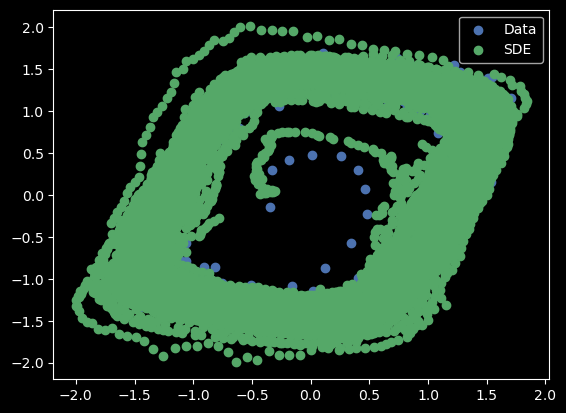

In [54]:
trial = -8
plt.scatter(data_tde[trial, ::10, 0], data_tde[trial, ::10, 1], label="Data")
plt.scatter(sol[trial, :, 0], sol[trial, :, 1], label="SDE")
plt.legend()
plt.show()

In [55]:
jnp.save("outputs/gen_vdp_data.npy", sol)

: 